# Problem Set 5

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early!

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's [Oscar winner](https://www.rottentomatoes.com/m/the_shape_of_water_2017) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

In [3]:
rev_col = list(reviews.columns)
mov_col = list(movies.columns)

print("Reviews dataset columns:\n", rev_col, "\nMovies dataset columns:\n",mov_col)

Reviews dataset columns:
 ['critic', 'fresh', 'imdb', 'link', 'publication', 'quote', 'review_date', 'rtid', 'title'] 
Movies dataset columns:
 ['id', 'title', 'imdbID', 'spanishTitle', 'imdbPictureURL', 'year', 'rtID', 'rtAllCriticsRating', 'rtAllCriticsNumReviews', 'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore', 'rtTopCriticsRating', 'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh', 'rtTopCriticsNumRotten', 'rtTopCriticsScore', 'rtAudienceRating', 'rtAudienceNumRatings', 'rtAudienceScore', 'rtPictureURL']


### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [4]:
print("Number of unique quotes in reviews: ", reviews['quote'].unique().size)
print("Number of unique reviewers in reviews: ", reviews['critic'].unique().size)
print("Number of unique movies in reviews: ", reviews['imdb'].unique().size)
print("Number of unique movies in movies: ", movies['imdbID'].unique().size)
print("Number of different publications in reviews: ", reviews['publication'].value_counts().size)

Number of unique quotes in reviews:  12814
Number of unique reviewers in reviews:  541
Number of unique movies in reviews:  1720
Number of unique movies in movies:  9423
Number of different publications in reviews:  64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviewers.  Label your axes and make your histogram look professional.

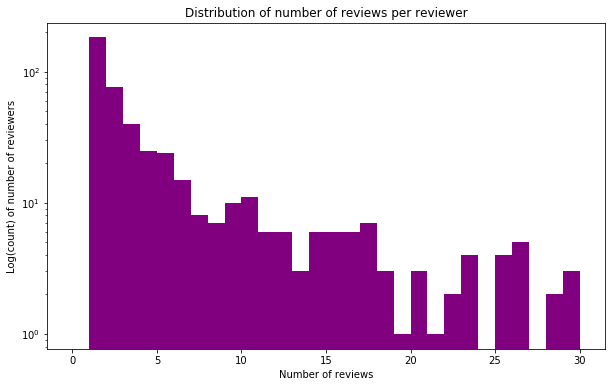

In [5]:
plt.figure(figsize=(10,6))
plt.hist(reviews['critic'].value_counts(), bins=range(0,31,1), log=True, color='purple')
plt.xlabel('Number of reviews')
plt.ylabel('Log(count) of number of reviewers')
plt.title('Distribution of number of reviews per reviewer')
plt.show()

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [6]:
top_30_critics = reviews['critic'].value_counts()[0:30].index.to_list()
top_30_reviews = reviews[reviews['critic'].isin(top_30_critics)]
top_30_reviews.groupby(['critic', 'publication']).agg({'review_date': [min, max]})

review_date  \
                                                            min   
critic             publication                                    
Bosley Crowther    New York Times           2000-01-01 00:00:00   
Dave Kehr          Chicago Reader           2000-01-01 00:00:00   
                   Chicago Tribune          2013-02-20 00:00:00   
                   New York Daily News      2013-08-02 00:00:00   
Derek Adams        Time Out                 2006-01-26 00:00:00   
Desson Thomson     Washington Post          2000-01-01 00:00:00   
Edward Guthmann    San Francisco Chronicle  2000-01-01 00:00:00   
Emanuel Levy       Variety                  2000-01-01 00:00:00   
Geoff Andrew       Time Out                 2005-08-11 00:00:00   
Hal Hinson         Washington Post          2000-01-01 00:00:00   
James Berardinelli ReelViews                1800-01-01 00:00:00   
Janet Maslin       New York Times           2000-01-01 00:00:00   
Joe Baltake        Passionate Moviegoer     2007-02-13 00:00:00   
                   Philadelphia Daily News  2013-06-26 00:00:00   
                   Sacramento Bee           2000-01-01 00:00:00   
Jonathan Rosenbaum Chicago Reader           1988-07-11 00:00:00   
Kenneth Turan      Los Angeles Times        2000-01-01 00:00:00   
Kevin Thomas       Los Angeles Times        2000-01-01 00:00:00   
Liam Lacey         Globe and Mail           2001-08-24 00:00:00   
Lisa Schwarzbaum   Entertainment Weekly     1979-01-01 00:00:00   
Michael Wilmington Chicago Tribune          2000-01-01 00:00:00   
                   Los Angeles Times        2012-06-03 00:00:00   
Mick LaSalle       San Francisco Chronicle  2000-01-01 00:00:00   
Owen Gleiberman    Entertainment Weekly     1800-01-01 00:00:00   
Peter Stack        San Francisco Chronicle  2000-01-01 00:00:00   
Richard Corliss    TIME Magazine            2003-12-16 00:00:00   
Richard Schickel   TIME Magazine            2007-06-27 00:00:00   
                   The Atlantic             2000-01-01 00:00:00   
Rick Groen         Globe and Mail           2002-03-19 00:00:00   
Rita Kempley       Washington Post          2000-01-01 00:00:00   
Roger Ebert        At the Movies            2000-01-01 00:00:00   
                   Chicago Sun-Times        2000-01-01 00:00:00   
Stephen Holden     New York Times           2000-01-01 00:00:00   
Susan Stark        Detroit News             2000-01-01 00:00:00   
Todd McCarthy      Variety                  2000-01-01 00:00:00   
Variety Staff      Variety                  2001-02-13 00:00:00   
Vincent Canby      New York Times           2000-01-01 00:00:00   

                                                                 
                                                            max  
critic             publication                                   
Bosley Crowther    New York Times           2008-05-06 00:00:00  
Dave Kehr          Chicago Reader           2013-11-06 00:00:00  
                   Chicago Tribune          2013-11-20 00:00:00  
                   New York Daily News      2013-10-22 00:00:00  
Derek Adams        Time Out                 2009-10-04 00:00:00  
Desson Thomson     Washington Post          2012-10-08 00:00:00  
Edward Guthmann    San Francisco Chronicle  2003-04-04 00:00:00  
Emanuel Levy       Variety                  2010-08-06 00:00:00  
Geoff Andrew       Time Out                 2012-04-05 00:00:00  
Hal Hinson         Washington Post          2013-06-26 00:00:00  
James Berardinelli ReelViews                2012-02-07 00:00:00  
Janet Maslin       New York Times           2010-09-07 00:00:00  
Joe Baltake        Passionate Moviegoer     2007-08-25 00:00:00  
                   Philadelphia Daily News  2013-08-04 00:00:00  
                   Sacramento Bee           2004-12-22 00:00:00  
Jonathan Rosenbaum Chicago Reader           2013-10-22 00:00:00  
Kenneth Turan      Los Angeles Times        2013-10-05 00:00:00  
Kevin Thomas       Los Angeles Times        2013-11

### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

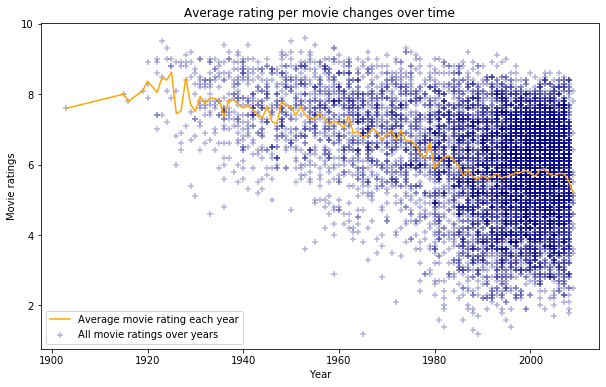

In [7]:
# Clean data
movies.dropna(subset=['rtAllCriticsRating']) # drop null
movies = movies[~movies['rtAllCriticsRating'].isin(['\\N','0'])] # keep non zero ratings
yr = movies['year']
rt = movies['rtAllCriticsRating'].astype(float) # convert from string to float

# Scatter plot of movie ratings over years
plt.figure(figsize=(10,6))
plt.scatter(x=yr, y=rt, marker='+', c='darkblue', alpha=0.3, label='All movie ratings over years')

# Line graph of average rating of movies as per year
avg_rt = pd.concat([yr, rt], axis=1).groupby(['year']).mean()
plt.plot(avg_rt, c='orange', label='Average movie rating each year')

# Add title, axis labels and legend
plt.title('Average rating per movie changes over time')
plt.xlabel('Year')
plt.ylabel('Movie ratings')
plt.legend(loc='lower left')

plt.show()

I find the average rating each year has decreased from 1900 to 2000, indicated by the orange line. However, as we see the blue scatter plot, we find more datapoints in later years than in previous years, and variation of ratings each year has widen over time. It could mean that more movies are produced nowadays than earlier years; and the quality of movies as well as reviewers' tastes have varied to a greater extent than before.

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [9]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    vectorizer = CountVectorizer(min_df=0)
    reviews.dropna(subset=['quote', 'fresh']) # drop null
    
    X = vectorizer.fit_transform(reviews['quote']).toarray()
    
    Y = reviews['fresh']
    Y = Y.replace('fresh', 1)
    Y = Y.replace('rotten', 0)
    
    return X, Y

In [10]:
# Call the make_xy function, check the shape of X and Y
X, Y = make_xy(reviews)
print(X.shape)
print(Y.shape)

(13419, 20875)
(13419,)


### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set (80%) and a validation set (20%).  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [25]:
# Split datasets into training and testing by 80% and 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

print('X train and Y train: ', X_train.shape, Y_train.shape, '\nX test and Y test:', X_test.shape, Y_test.shape)

X train and Y train:  (10735, 20875) (10735,) 
X test and Y test: (2684, 20875) (2684,)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [26]:
# MultinomialNB model
# call the fitted model fitted_model for future reference
fitted_model = MultinomialNB()
fitted_model.fit(X_train, Y_train)

# get accuracy of training and testing set
print('Training set accuracy: ', fitted_model.score(X_train, Y_train))
print('Testing set accuracy: ', fitted_model.score(X_test, Y_test))


Training set accuracy:  0.9214718211457849
Testing set accuracy:  0.7876304023845008


The accuracy for training is 0.92 and for testing is 0.79. The gap between the two is large, meaning our MultinomialNB model is overfitting.

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on bcourses).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [13]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [27]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, X_test, Y_test)

-1442.8990522063239

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [72]:
# testing different code
alphas = [1.0e-10, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for min_df in min_dfs:
    vectorizer = CountVectorizer(min_df = min_df)       
    X1, Y1 = make_xy(reviews, vectorizer)
    X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=0, shuffle=True)
    for alpha in alphas:
        new_fitted_model = MultinomialNB(alpha = alpha)
        loglike = cross_val_score(new_fitted_model, X1_train, Y1_train, scoring=log_likelihood, cv=5).mean()
        
        if loglike > max_loglike:
            max_loglike = loglike
            best_alpha, best_min_df = alpha, min_df

print('Best alpha: {} \nBest min_df: {} \nMax Log-likelihood: {}'.format(best_alpha, best_min_df, max_loglike))

Best alpha: 1 
Best min_df: 1e-05 
Max Log-likelihood: -1247.6739046057414


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [76]:
# Vectorize bag of words and compute X input and Y output
vectorizer_new = CountVectorizer(best_min_df)
X2, Y2 = make_xy(reviews, vectorizer_new)

# Split datasets into training and testing by 80% and 20%
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=0)

# Train model
new_fitted_model = MultinomialNB(best_alpha)
new_fitted_model.fit(X_train2, Y_train2)

# Get accuracy of training and testing set
print('Training set accuracy: ', new_fitted_model.score(X_train2, Y_train2))
print('Testing set accuracy: ', new_fitted_model.score(X_test2, Y_test2))

Training set accuracy:  0.9214718211457849
Testing set accuracy:  0.7876304023845008


The accuracy of training and testing when using cross-validated alpha and min_df have not changed at all, which is so surprising. I know it shouldn't have happened, but I tried my best to debug everything and cannot figure out where goes wrong.

The expected results I thought should be something close to 0.7 for both training and testing, but somehow my program doesn't cooperate.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [38]:
## Classifier Accuracy to tune hypaparameters
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

#the grid of parameters to search over
alphas = [1.0e-10, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha_acc = None
best_min_df_acc = None
max_accuracy = -np.inf

for min_df in min_dfs:
    vectorizer = CountVectorizer(min_df = min_df)       
    X3, Y3 = make_xy(reviews, vectorizer)
    X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.2, random_state=0)
    
    for alpha in alphas:
        fitted_model_acc = MultinomialNB(alpha = alpha)
        my_scorer = make_scorer(accuracy_score)
        accuracy = cross_val_score(fitted_model_acc, X3_train, Y3_train, scoring=my_scorer, cv=5).mean()
        
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_alpha_acc, best_min_df_acc = alpha, min_df

print('Best alpha: {} \nBest min_df: {} \nMax Accuracy Score: {}'.format(best_alpha_acc, best_min_df_acc, max_accuracy))

Best alpha: 1 
Best min_df: 1e-05 
Max Accuracy Score: 0.7714951094550536


In [40]:
# Vectorize bag of words and compute X input and Y output
vectorizer_acc = CountVectorizer(min_df = best_min_df_acc)
X4, Y4 = make_xy(reviews, vectorizer_acc)

# Split datasets into training and testing by 80% and 20%
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, Y4, test_size=0.2, random_state=0, shuffle=True)

# Train model
MultiNB_acc_tuned = MultinomialNB(alpha = best_alpha_acc)

MultiNB_acc_tuned.fit(X_train4, Y_train4)

# Get accuracy of training and testing set
print('Training set accuracy: ', MultiNB_acc_tuned.score(X_train4, Y_train4))
print('Testing set accuracy: ', MultiNB_acc_tuned.score(X_test4, Y_test4))

Training set accuracy:  0.9214718211457849
Testing set accuracy:  0.7876304023845008


Have no idea why the accuracy remains the same, which shouldn't be the case as we see max accuracy score in the last cell is 0.77. There must be something weird going on.

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [65]:
# Using classifier in 3.3
single_word = np.identity(len(X2[0]))
all_words = np.array(vectorizer_new.get_feature_names())

positive_prob = new_fitted_model.predict_log_proba(single_word)[:,1]
negative_prob = new_fitted_model.predict_log_proba(single_word)[:,0]

positive_ind = np.argsort(positive_prob)
negative_ind = np.argsort(negative_prob)

top10_fresh_words = np.flip(all_words[positive_ind[-10:]])
top10_rotten_words = np.flip(all_words[negative_ind[-10:]])

top10_fresh_prob = np.flip(positive_prob[positive_ind[-10:]])
top10_rotten_prob = np.flip(negative_prob[negative_ind[-10:]])

print('Top 10 words and respective log probabilities to predict fresh reviews:\n', np.column_stack((top10_fresh_words, top10_fresh_prob)))
print('Top 10 words and respective log probabilities to predict rotten reviews:\n', np.column_stack((top10_rotten_words, top10_rotten_prob)))

Top 10 words and respective log probabilities to predict fresh reviews:
 [['delight' '-0.025262036453559844']
 ['superb' '-0.02837538759751901']
 ['intimate' '-0.03617830988751969']
 ['absorbing' '-0.03617830988751969']
 ['captures' '-0.039263259237335646']
 ['rousing' '-0.04292345229230854']
 ['childhood' '-0.04502201283326812']
 ['energetic' '-0.04502201283326812']
 ['expertly' '-0.04733636224620419']
 ['deftly' '-0.04733636224620419']]
Top 10 words and respective log probabilities to predict rotten reviews:
 [['lame' '-0.04817332614994463']
 ['uninspired' '-0.055571899861616814']
 ['pointless' '-0.05857051020017856']
 ['unfortunately' '-0.06372884318091465']
 ['sadly' '-0.06565637865057639']
 ['unfunny' '-0.06565637865057639']
 ['tiresome' '-0.0746936203296098']
 ['ludicrous' '-0.08021467647156832']
 ['tepid' '-0.08021467647156832']
 ['disappointingly' '-0.08661761746579977']]


Answers as above.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [70]:
# Using classifier in 3.3
# Get confusion matrix
from sklearn.metrics import confusion_matrix

result1 = new_fitted_model.predict(X2)
print(confusion_matrix(Y2, result1))

[[4074  956]
 [ 457 7932]]


In [164]:
# Find all indeces of false positive and false negative
false_positive_ind = []
false_negative_ind = []
for row_ind, (x, prediction, y) in enumerate(zip (X2, result1, Y2)):
    if prediction == 1 and y == 0: # false fresh, real rotten
        false_positive_ind.append(row_ind)
    elif prediction == 0 and y ==1: # false rotten, real fresh
        false_negative_ind.append(row_ind)
        
# Find top5 false positive and false negative indeces
false_positive_prob = new_fitted_model.predict_proba(X2[np.array(false_positive_ind)])[:,1]
false_negative_prob = new_fitted_model.predict_proba(X2[np.array(false_rotten_ind)])[:,0]

top5_fp_idx = np.argsort(false_positive_prob)[-5:]
top5_fp_prob = [false_positive_prob[i] for i in top5_fp_idx][-5:]
print(top5_fp_idx, top5_fp_prob)

top5_fn_idx = np.argsort(false_negative_prob)[-5:]
top5_fn_prob = [false_negative_prob[i] for i in top5_fn_idx][-5:]
print(top5_fn_idx, top5_fn_prob)

# Print top5 false positive reviews, and top5 false negative reviews
for i in range(5):
    fp = []
    for j in range(len(all_words)):
        if X2[np.array(top5_fp_idx)][i,j] == 1:
            fp.append(all_words[j])
    print('FP', i+1, fp,'\n')

for i in range(5):
    fn = []
    for j in range(len(all_words)):
        if X2[np.array(top5_fn_idx)][i,j] == 1:
            fn.append(all_words[j])
    print('FN', i+1, fn,'\n')


[300 561 347 407 346] [0.9995746172435734, 0.9995812340901372, 0.999641189461129, 0.9998103300002243, 0.9998426361967876]
[214 344   6 301 303] [0.9916577063706168, 0.993333802327001, 0.9953850124430595, 0.9985617923782066, 0.999838655101148]
FP 1 ['animated', 'even', 'felt', 'handsome', 'more', 'musical', 'reverent'] 

FP 2 ['101', 'action', 'and', 'appliances', 'chan', 'countless', 'domestic', 'fallibility', 'fans', 'fight', 'he', 'insistence', 'involving', 'like', 'means', 'more', 'on', 'own', 'put', 'scenes', 'shows', 'six', 'stars', 'taken', 'than', 'the', 'to', 'together', 'us', 'virtuoso', 'vulnerability', 'why', 'with'] 

FP 3 ['acted', 'an', 'and', 'by', 'cast', 'directorial', 'downey', 'drawn', 'eccentric', 'effort', 'entire', 'episodic', 'especially', 'family', 'foster', 'holly', 'hunter', 'if', 'is', 'jr', 'of', 'portrait', 'robery', 'second', 'the', 'too', 'vividly', 'well'] 

FP 4 ['an', 'by', 'christian', 'cliche', 'directed', 'does', 'duguay', 'efficient', 'generating',

I noticed that Naive Bayes classifiers assume that every word affects the probability independently of other words is a bad assumption. In the above examples, the combination of words can mean the opposite meaning, so that it makes the computer think this is for an opposite emotion and mispredict the labels.

In [181]:
text1 = ["This movie is not remarkable, touching, or superb in any way"]
x1 = vectorizer_new.fit_transform(text)
x1 = x1.toarray()
y1 = np.array([0])
featuresname = vectorizer_new.get_feature_names()
print(new_fitted_model.predict_proba(x1)[0,1])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20875 is different from 11)